In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# wrangling
import pandas as pd
import numpy as np

# preparing
from sklearn.model_selection import train_test_split

# visualizing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# exploring
import scipy.stats as stats
import pandas_profiling

# modeling
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
from sklearn.neighbors import KNeighborsRegressor

# 3D projection
from mpl_toolkits.mplot3d import Axes3D

pd.options.display.float_format = '{:20,.2f}'.format

# my modules
import acquire
import summarize
import prepare

# default pandas decimal number display format
pd.options.display.float_format = '{:20,.2f}'.format

## Acquire

- 2017 data

- Used only latest transaction property id.

- Used only properties with single family homes.

- Acquired zillow data using acquire.py (sequel query in this file)

- Exported df to a csv file for faster loading.

In [2]:
# df = acquire.get_zillow_data()
# df.head()

In [3]:
# Reads in a df with 52,169 rows and 21 columns

df = pd.read_csv("zillow_dataframe.csv")

In [4]:
df.shape

(52169, 21)

## Prepare

- Starting stage with 52,169 rows and 19 columns


- This stage will be revisted often as data needs dictate.


- Drop columns not needed based on previous and ongling exploration:

    - "Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"
    
    
- Keep garagecacnt and poolcnt for exploration and possible feature engineering purposed.


- Manually scale latitude and longitude by dividing by 1 million.


- Create the following new variables for exploration and modeling

    - price_per_sq_ft: (value of house / house square footage)
    
    - land_price_per_sq_ft: (land tax value / lot square footage)
    
    - cluster: Los Angeles == 0, Ventura == 1, Orange == 2
    
    
- Split data into train and test
    
    
- Fill zeros for missing values in garagecarcnt and poolcnt

    - explore these columns for possible feature engineering in this or future iterations of project
    
    
- Drop remaining rows with Nulls to get data ready to model
    - train df
        - lotsizesquarefeet               251
        - yearbuilt                        26
        - price_per_sq_ft                   3
        - lot_price_per_sq_ft             251
    - test df
        - tax_rate                          1
        - calculatedfinishedsquarefeet      5
        - lotsizesquarefeet               103
        - taxvaluedollarcnt                 1
        - yearbuilt                        14
        - landtaxvaluedollarcnt             1
        - price_per_sq_ft                   6
        - lot_price_per_sq_ft             104


- Final train and test df sizes at the end of prepare-  

    - train = (36238, 20)
    - test = (15532, 20)
    
    

In [5]:
# drop columns that will not be needed for explore or model

df = df.drop(columns=["Unnamed: 0", "garagetotalsqft", "poolsizesum", "taxdelinquencyflag", "taxdelinquencyyear", "transactions"])

In [6]:
df.shape

(52169, 15)

In [7]:
# Manually scale lat and long from very large numbers by dividing by 1 million

df.latitude = df.latitude / 1_000_000 
df.longitude = df.longitude / 1_000_000 

### Create New Features:

- price_per_sq_ft (value of house / house square footage

- land_price_per_sq_ft  (land tax value / lot square footage)

#### Might need to find and drop the outliers for price per sq ft.  Probably some with extremely low or extremely high values that don't make sense

In [8]:
df['price_per_sq_ft'] = df['taxvaluedollarcnt'] / df['calculatedfinishedsquarefeet']
df['lot_price_per_sq_ft'] = df['landtaxvaluedollarcnt'] / df['lotsizesquarefeet']

In [9]:
df.head(1)

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,33.63,-117.87,"4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange,330.09,119.30


In [10]:
# df = df.drop(columns=['calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

### Split the data into train and test, 70/30

In [11]:
train, test = train_test_split(df, test_size=.30, random_state=123)

In [12]:
train.shape

(36518, 17)

In [13]:
test.shape

(15651, 17)

### Proof of Concept - Clustering fips (aka binning the 3 different counties)

In [14]:
kmeans = KMeans(n_clusters=3, n_init=1, max_iter=100, random_state=123)

In [15]:
kmeans.fit(train[['fips']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=3, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [16]:
cluster = 'cluster_' + str('fips')

train[cluster] = kmeans.predict(train[['fips']])

test[cluster] = kmeans.predict(test[['fips']])

Elbow method to determine how many clusters are necessary

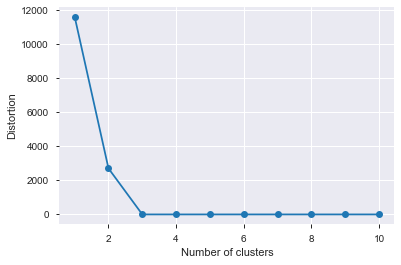

In [17]:
X1 = train[['cluster_fips']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X1)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

## Clustering based on price per square foot, latitude, and longitude

In [18]:
kmeans = KMeans(n_clusters=10, n_init=1, max_iter=100, random_state=123)

In [19]:
train.isnull().sum()

tax_rate                            4
bathroomcnt                         0
bedroomcnt                          0
calculatedfinishedsquarefeet        3
fips                                0
garagecarcnt                    23949
latitude                            0
longitude                           0
lotsizesquarefeet                 251
poolcnt                         28752
taxvaluedollarcnt                   0
yearbuilt                          26
landtaxvaluedollarcnt               0
logerror                            0
county_name                         0
price_per_sq_ft                     3
lot_price_per_sq_ft               251
cluster_fips                        0
dtype: int64

In [20]:
train[pd.isnull(train['price_per_sq_ft'])]

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips
45269,0.01,1.00,1.00,nan,"6,059.00",nan,33.72,-117.90,"5,579.00",nan,"131,534.00",nan,"92,903.00",-0.32,Orange,nan,16.65,0
4438,0.01,1.00,2.00,nan,"6,059.00",nan,33.90,-117.84,"7,005.00",nan,"488,078.00",nan,"418,475.00",-0.05,Orange,nan,59.74,0
15701,0.01,1.00,2.00,nan,"6,059.00",nan,33.60,-117.87,"3,381.00",nan,"107,267.00",nan,"59,613.00",-0.01,Orange,nan,17.63,0


In [21]:
train = train[pd.notnull(train['price_per_sq_ft'])]

In [22]:
test = test[pd.notnull(test['price_per_sq_ft'])]

In [23]:
kmeans.fit(train[['price_per_sq_ft', 'latitude', 'longitude']])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=100,
       n_clusters=10, n_init=1, n_jobs=None, precompute_distances='auto',
       random_state=123, tol=0.0001, verbose=0)

In [24]:
cluster = 'cluster_' + str('sqft')

train[cluster] = kmeans.predict(train[['price_per_sq_ft', 'latitude', 'longitude']])

test[cluster] = kmeans.predict(test[['price_per_sq_ft', 'latitude', 'longitude']])

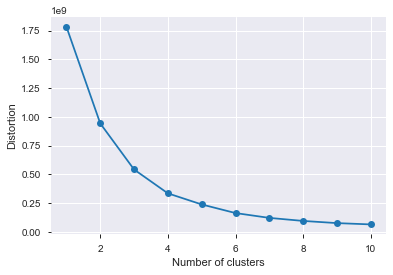

In [25]:
X2 = train[['price_per_sq_ft', 'latitude', 'longitude']]
# calculate distortion for a range of numbers of clusters
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=0
    )
    km.fit(X2)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

### Encode clusters

In [26]:
train_cluster_fips = train.drop(columns='cluster_sqft')
test_cluster_fips = test.drop(columns='cluster_sqft')

In [27]:
train_cluster_sqft = train.drop(columns='cluster_fips')
test_cluster_sqft = test.drop(columns='cluster_fips')

In [28]:
train_cluster_fips, test_cluster_fips, ohe1 = prepare.encode(train_cluster_fips, test_cluster_fips, 'cluster_fips')
train_cluster_sqft, test_cluster_sqft, ohe2 = prepare.encode(train_cluster_sqft, test_cluster_sqft, 'cluster_sqft')

### Drop cluster column and rename clusters as county names

In [29]:
train_cluster_fips = train_cluster_fips.drop(columns='cluster_fips')

train_cluster_fips['los_angeles'] = train_cluster_fips['cluster_fips_0']
train_cluster_fips['ventura'] = train_cluster_fips['cluster_fips_1']
train_cluster_fips['orange'] = train_cluster_fips['cluster_fips_2']

train_cluster_fips = train_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

In [30]:
test_cluster_fips = test_cluster_fips.drop(columns='cluster_fips')

test_cluster_fips['los_angeles'] = test_cluster_fips['cluster_fips_0']
test_cluster_fips['ventura'] = test_cluster_fips['cluster_fips_1']
test_cluster_fips['orange'] = test_cluster_fips['cluster_fips_2']

test_cluster_fips = test_cluster_fips.drop(columns=['cluster_fips_0', 'cluster_fips_1', 'cluster_fips_2'])

### Impute 

- "poolcnt", "garagecarcnt" with zeros

 - Run this on train and test subsets separately

In [31]:
# Impute zeros into poolcnt and garagecarcnt on train set

train.poolcnt.fillna(value=0, inplace=True)
test.poolcnt.fillna(value=0, inplace=True)

train_cluster_sqft.poolcnt.fillna(value=0, inplace=True)
test_cluster_sqft.poolcnt.fillna(value=0, inplace=True)

In [32]:
# Impute zeros into poolcnt and garagecarcnt on test set
train.garagecarcnt.fillna(value=0, inplace=True)
test.garagecarcnt.fillna(value=0, inplace=True)

train_cluster_sqft.garagecarcnt.fillna(value=0, inplace=True)
test_cluster_sqft.garagecarcnt.fillna(value=0, inplace=True)

### Drop Nulls 

- drop rows with remaining missing values to get clean train and test data sets

In [33]:
train.dropna(inplace=True)
test.dropna(inplace=True)

train_cluster_sqft.dropna(inplace=True)
test_cluster_sqft.dropna(inplace=True)

### THE train and test subsets 

- no missing values and poolcnt and garagecarcnt imputed with zeros. 

- Outliers still in these subsets!

- I left county_name in these df for ease of exploration and viz. 

- Drop county_name and use fips for modeling and clustering purposes.

- If you want train and test with defined categories and outliers handled, see train_cat and test_cat below

In [34]:
train.isnull().sum()
train.shape

(36238, 19)

In [35]:
test.isnull().sum()
test.shape

(15532, 19)

In [36]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_sqft
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76,0,1
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50,1,8
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09,0,5
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78,1,9
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06,1,5


---

## Data Dictionary

- tax_rate                        float64

    - calculated column using taxamount/taxvaluedollarcnt
    
- bathroomcnt                     float64

    - number of full and half baths
    
- bedroomcnt                      float64

    - number of bedrooms

- calculatedfinishedsquarefeet    float64

    - square footage of entire home

- fips                            float64

    - county codes
 https://www.nrcs.usda.gov/wps/portal/nrcs/detail/national/home/?cid=nrcs143_013697

- garagecarcnt                    float64

    - number of car garage (34203 missing values in original df)

- latitude                        float64

    - latitude divided by 1 million

- longitude                       float64

    - longitude divided by 1 million

- lotsizesquarefeet               float64

    - size of lot in square feet

- poolcnt                         float64

    - number of pools (41105 missing values in original df)

- taxvaluedollarcnt               float64

    - home value in US dollars

- yearbuilt                       float64

    - year the home was built (1878 - 2015)

- landtaxvaluedollarcnt           float64

    - land value in US dollars

- logerror                        float64

    - the difference between the Zestimate and the actual sales price (our target variable)

- county_name                     object

    - Los Angeles, Orange, Ventura counties derived from fips codes

- price_per_sq_ft                 float64

    - calculated column using taxvaluedollarcnt / calculatedfinishedsquareft

- lot_price_per_sq_ft             float64

    - calculated columns using landtaxvaluedollarcnt / lotsizesquarefeet

- los_angeles                     float64

    - binned column with 1 indicating a home in Los Angeles county, 0 if not

- ventura                         float64

    - binned column with 1 indicating a home in Ventura county, 0 if not

- orange                          float64

    - binned column with 1 indicating a home in Orange county, 0 if not

----

## Explore 

### County Overview

In [37]:
train_cluster_fips.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,los_angeles,ventura,orange
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",nan,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76,1.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",nan,34.05,-118.08,"10,906.00",nan,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09,1.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",nan,34.45,-118.57,"6,252.00",nan,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78,0.00,1.00,0.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",nan,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06,0.00,1.00,0.00


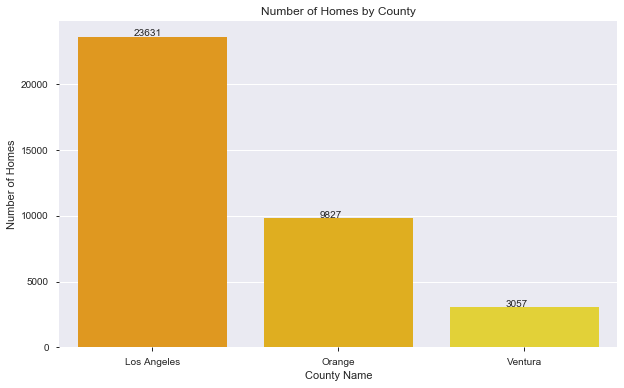

In [38]:
plt.rcParams["figure.figsize"] = (10,6)

ax = sns.countplot(data=train_cluster_fips, x='county_name', order=['Los Angeles', 'Orange', 'Ventura'], palette='Wistia_r')

for p in ax.patches:
        ax.annotate('{:.0f}'.format(p.get_height()), (p.get_x()+0.3, p.get_height()+50))
        
plt.title('Number of Homes by County')
plt.xlabel('County Name')
plt.ylabel('Number of Homes')
plt.show()

### Heatmap

In [39]:
# do a quick drop of the columns below just for this heat map. They are just clutter here.

# heatmap_df = train.drop(columns=['los_angeles', 'orange', 'ventura', 'fips'])

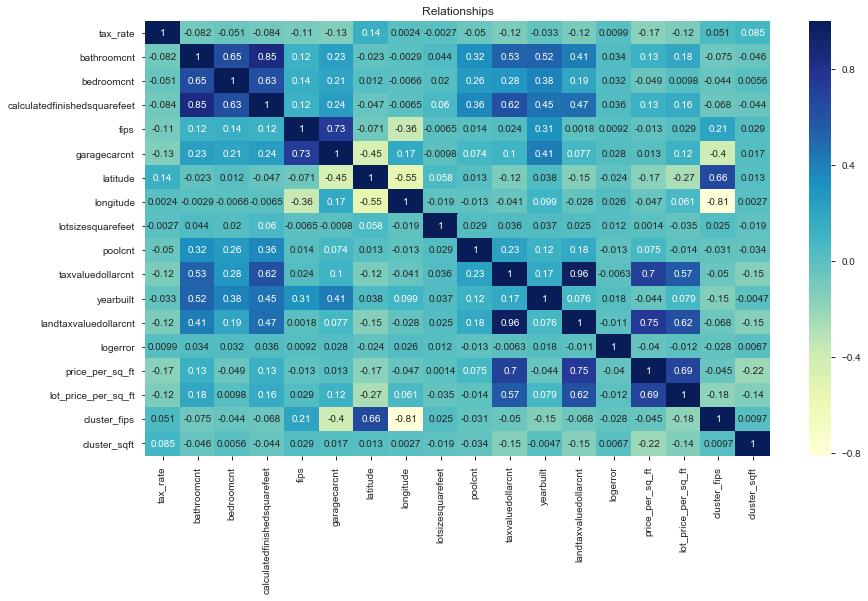

In [40]:
plt.figure(figsize=(14,8))
sns.heatmap(train.corr(), annot=True, cmap="YlGnBu")

plt.title('Relationships')
plt.show()

#### Takeaways: Heatmap 

- There is nothing highly correlated with logerror.

- The new columns price_per_sq_ft and lot_price_per_sq_ft have more of a correlation with logerror than the more general columns they are based on, taxvaluedollarcnt and landtaxvaluedollarcnt.

### Explore: Price and Logerror

In [41]:
# price_per_sq_ft by county

price = train.groupby('county_name').price_per_sq_ft.mean()
price

county_name
Los Angeles                 257.36
Orange                      273.82
Ventura                     237.58
Name: price_per_sq_ft, dtype: float64

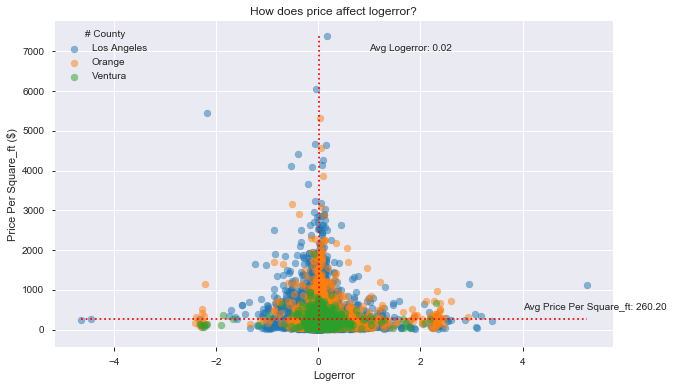

In [42]:
plt.rcParams["figure.figsize"] = (10,6)

for county in sorted(df.county_name.unique()):
    subset = df[df.county_name == county]
    plt.scatter(subset.logerror, subset.price_per_sq_ft, label=county, alpha=.5)
    plt.legend(title='# County', loc='upper left')
    
plt.xlabel('Logerror')
plt.ylabel('Price Per Square_ft ($)')
plt.title('How does price affect logerror?')

plt.hlines(df.price_per_sq_ft.mean(), df.logerror.min(), df.logerror.max(), ls=':', color='red')
plt.vlines(df.logerror.mean(), df.price_per_sq_ft.min(), df.price_per_sq_ft.max(), ls=':', color='red')

plt.annotate(
    f'Avg Logerror: {df.logerror.mean():.2f}',
    xy=(df.logerror.mean(), 40),
    xytext=(1, 7000)
)

plt.annotate(
    f'Avg Price Per Square_ft: {df.price_per_sq_ft.mean():.2f}',
    xy=(5, df.price_per_sq_ft.mean()),
    xytext=(4, 500)
)

plt.show()

#### By County

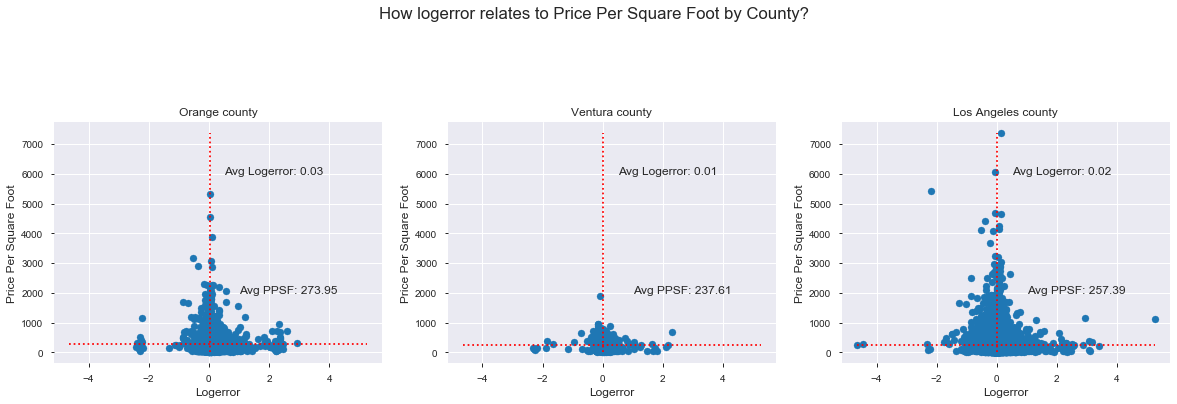

In [43]:
plt.rc('figure', figsize=(20, 16))
plt.rc('axes', grid=True)
plt.rc('axes.spines', top=False, right=False, left=True, bottom=True)
plt.rc('font', size=14)

for i, county in enumerate(df.county_name.unique()):
    plt.subplot(3, 3, i+1)
    subset = df[df.county_name == county]
    plt.scatter(subset.logerror, subset.price_per_sq_ft, label=county)
    
    plt.title(f'{county} county', size=12)
    plt.xlabel('Logerror', size=12)
    plt.ylabel('Price Per Square Foot', size=12)
    
    plt.hlines(subset.price_per_sq_ft.mean(), df.logerror.min(), df.logerror.max(), ls=':', color='red')
    plt.vlines(subset.logerror.mean(), df.price_per_sq_ft.min(), df.price_per_sq_ft.max(), ls=':', color='red')
    
    plt.annotate(
    f'Avg Logerror: {subset.logerror.mean():.2f}',
    xy=(subset.logerror.mean(), 10),
    xytext=(.5, 6000),
    size=12
    )

    plt.annotate(
    f'Avg PPSF: {subset.price_per_sq_ft.mean():.2f}',
    xy=(5, subset.price_per_sq_ft.mean()),
    xytext=(1, 2000),
    size=12
    )
    #plt.xlim(-4, 4)
    #plt.ylim(0, 7000)

plt.subplots_adjust(hspace=.3)
plt.suptitle('How logerror relates to Price Per Square Foot by County?')

plt.show()

#### Takeaways:  Price Per Square Foot and Logerror

- Orange County has the highest price per square foot and the highest logerror.

- Ventura has the lowest price per square foot and the lowest logerror.

---

### Explore:  Bedroom and Bathroom

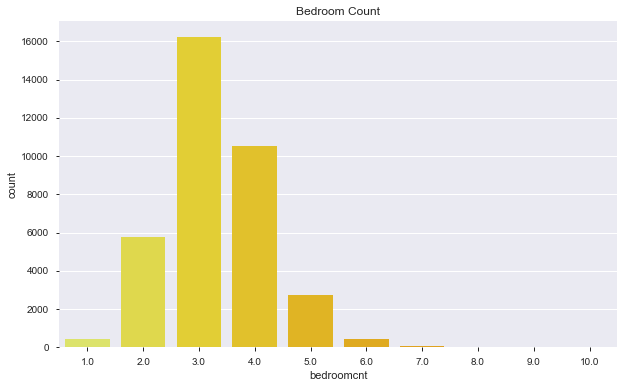

In [44]:
plt.rcParams["figure.figsize"] = (10,6)
#plt.rc('figure', figsize=(12, 8))
sns.countplot(x='bedroomcnt', palette="Wistia", data=train)

plt.title('Bedroom Count')
plt.show()

In [45]:
train_cluster_sqft.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,...,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,...,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,...,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [46]:
train.bedroomcnt.value_counts().sort_index()

 1.00      418
 2.00     5784
 3.00    16241
 4.00    10523
 5.00     2726
 6.00      446
 7.00       72
 8.00       20
 9.00        6
10.00        2
Name: bedroomcnt, dtype: int64

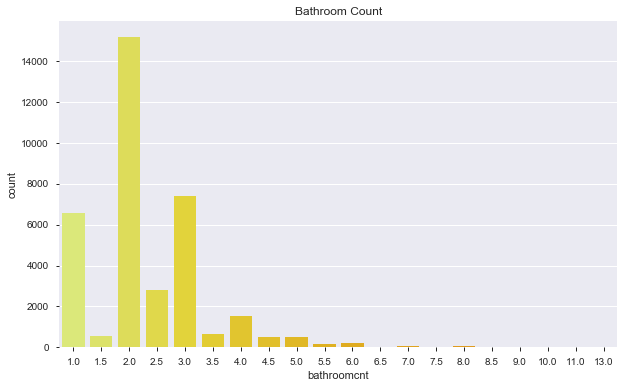

In [47]:
plt.rcParams["figure.figsize"] = (10,6)

sns.countplot(x='bathroomcnt', palette="Wistia", data=train)

plt.title('Bathroom Count')
plt.show()

In [48]:
train.bathroomcnt.value_counts().sort_index()

 1.00     6584
 1.50      573
 2.00    15201
 2.50     2800
 3.00     7392
 3.50      628
 4.00     1522
 4.50      481
 5.00      525
 5.50      160
 6.00      209
 6.50       35
 7.00       57
 7.50       14
 8.00       40
 8.50        1
 9.00       10
10.00        3
11.00        2
13.00        1
Name: bathroomcnt, dtype: int64

#### Takeaways: Bedroom and Bathroom 

- Use remove_outliers_iqr to drop rows with bedroom or bathroom counts outside upper and lower bounds

    - Upper bound = Q3 + 1.5 * IQR
    - Lower bound = Q1 - 1.5 * IQR
    
- The most typical home is a 3 bedroom, 2 bathroom home.

---

### Handle outliers 

- remove values < Q1 - IQR * 1.5 and values > Q3 + IQR * 1.5

In [49]:
train = prepare.remove_outliers_iqr(train, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
train.shape

(34447, 19)

In [50]:
test = prepare.remove_outliers_iqr(test, columns=["bedroomcnt", "bathroomcnt"], k=1.5)
test.shape

(14789, 19)

### After Outliers 

- remove rows with values above 5 bedrooms and 4.5 bathrooms

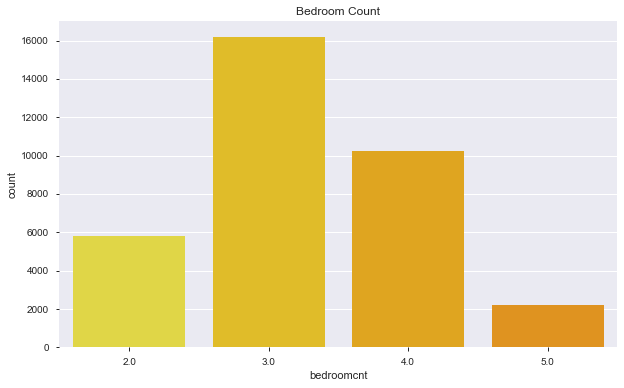

In [51]:
plt.rcParams["figure.figsize"] = (10,6)

sns.countplot(x='bedroomcnt', palette="Wistia", data=train)

plt.title('Bedroom Count')
plt.show()

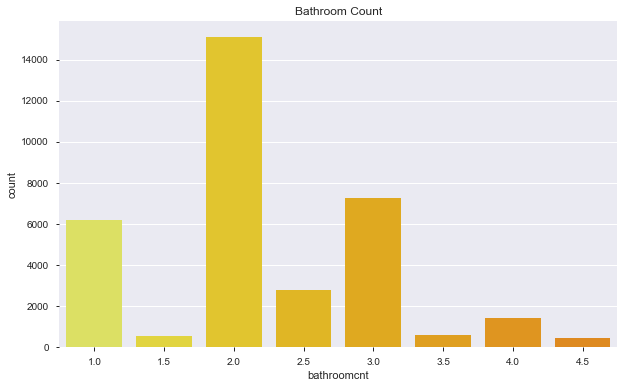

In [52]:
plt.rcParams["figure.figsize"] = (10,6)

sns.countplot(x='bathroomcnt', palette="Wistia", data=train)

plt.title('Bathroom Count')
plt.show()

In [53]:
train.bedroomcnt.value_counts()

3.00    16201
4.00    10242
2.00     5782
5.00     2222
Name: bedroomcnt, dtype: int64

In [54]:
train.bathroomcnt.value_counts()

2.00    15122
3.00     7275
1.00     6215
2.50     2788
4.00     1410
3.50      614
1.50      572
4.50      451
Name: bathroomcnt, dtype: int64

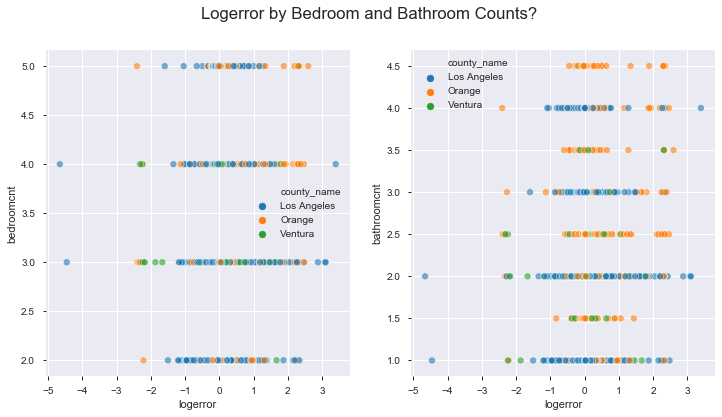

In [55]:
f, axes = plt.subplots(1, 2, figsize=(12,6))

p1 = sns.scatterplot(data=train, y="bedroomcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[0])
p2 = sns.scatterplot(data=train, y="bathroomcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[1])

plt.subplots_adjust(hspace=.3)
plt.suptitle('Logerror by Bedroom and Bathroom Counts?')
plt.legend(loc='upper left')
plt.show()

#### Takeaways:  Bedroom and Bathroom Counts

- The logerror is higher for the more typical homes of 3 bedrooms and 2 bathrooms.

- The homes with half baths have lower logerrors.

---

### Explore: price_per_sq_ft vs. taxvaluedollarcnt

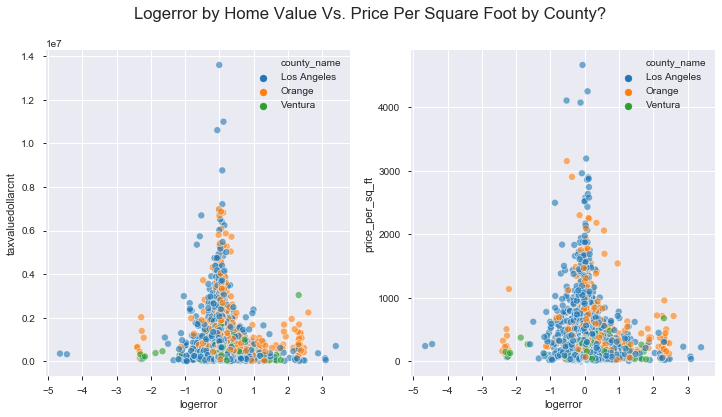

In [56]:
f, axes = plt.subplots(1, 2, figsize=(12,6))

p1 = sns.scatterplot(data=train, y="taxvaluedollarcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[0])
p2 = sns.scatterplot(data=train, y="price_per_sq_ft", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[1])

plt.subplots_adjust(hspace=.3)
plt.suptitle('Logerror by Home Value Vs. Price Per Square Foot by County?')

plt.show()

#### Takeaways: price_per_sq_ft 

- Using price_per_sq_ft instead of taxvaluedollarcnt offers better insight into logerror.


- Zillow's log error was low on the higher priced outliers.  


- The lower the price per square foot, the higher the log error, the lower the accuracy of the Zestimate.

---

### Explore Variable Relationships 

- using new feature price_per_sq_ft

### Explore: Year Built Vs. Logerror

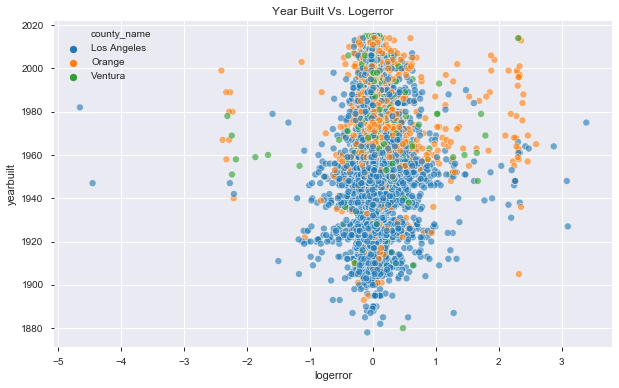

In [57]:
plt.rcParams["figure.figsize"] = (10,6)

sns.scatterplot(data=train, y="yearbuilt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)
plt.title("Year Built Vs. Logerror")
plt.show()

#### Takeaways: Year Built and Logerror

- Orange and Ventura counties have had lots of market growth since the 1950s.

- Orange county has the highest logerror, .03, and highest price per square foot, $273.95, of all the counties.

- The newer homes and growing market may be more difficult to predict with the algorithm Zillow is using.

In [58]:
df.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft
0,0.01,3.50,4.00,"3,100.00","6,059.00",2.00,33.63,-117.87,"4,506.00",nan,"1,023,282.00","1,998.00","537,569.00",0.03,Orange,330.09,119.30
1,0.01,1.00,2.00,"1,465.00","6,111.00",1.00,34.45,-119.28,"12,647.00",nan,"464,000.00","1,967.00","376,000.00",0.06,Ventura,316.72,29.73
2,0.01,2.00,3.00,"1,243.00","6,059.00",2.00,33.89,-117.82,"8,432.00",1.00,"564,778.00","1,962.00","479,489.00",0.01,Orange,454.37,56.87
3,0.01,3.00,4.00,"2,376.00","6,037.00",nan,34.25,-118.24,"13,038.00",1.00,"145,143.00","1,970.00","36,225.00",-0.10,Los Angeles,61.09,2.78
4,0.01,3.00,4.00,"2,962.00","6,037.00",nan,34.15,-118.18,"63,000.00",1.00,"773,303.00","1,950.00","496,619.00",-0.00,Los Angeles,261.07,7.88


In [59]:
train.longitude.isnull().sum()

0

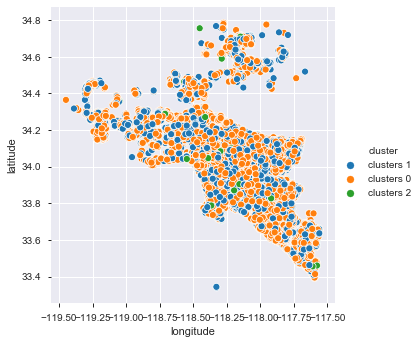

In [60]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(X2)

X2['cluster'] = 'clusters ' + pd.Series(kmeans.predict(X2)).astype(str)

sns.relplot(data=X2, hue='cluster', x='longitude', y='latitude')

Text(0.5, 0.98, 'Logerror by Latitude and Longitude')

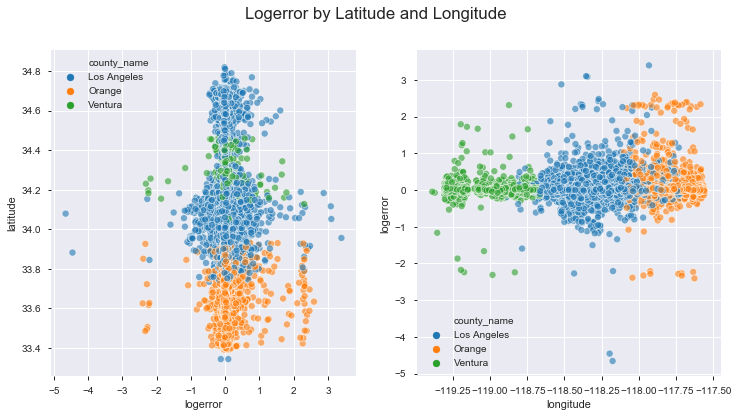

In [61]:
f, axes = plt.subplots(1, 2, figsize=(12,6))

p1 = sns.scatterplot(data=train, y="latitude", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[0])
p2 = sns.scatterplot(data=train, x="longitude", y="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6, ax=axes[1])

plt.subplots_adjust(hspace=.3)
plt.suptitle('Logerror by Latitude and Longitude')

### Explore:  Garages by County

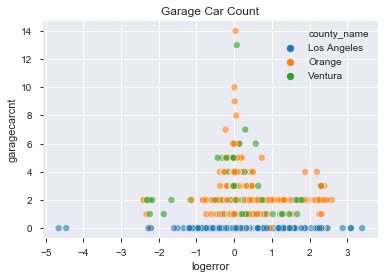

In [62]:
# What happened to caragecarcnt in Los Angeles? 1?! This data is rough...

plt.rcParams["figure.figsize"] = (6,4)
sns.scatterplot(data=train, y="garagecarcnt", x="logerror", hue='county_name', hue_order=["Los Angeles", "Orange", "Ventura"], alpha=.6)

plt.title('Garage Car Count')
plt.show()

In [63]:
train.groupby(['county_name']).garagecarcnt.value_counts().sort_index()

county_name  garagecarcnt
Los Angeles   0.00           22136
              2.00               1
Orange        0.00             249
              1.00            1133
              2.00            7659
              3.00             238
              4.00              78
              5.00              10
              6.00               5
              7.00               1
              8.00               1
              9.00               1
             10.00               1
             14.00               1
Ventura       0.00              43
              1.00             310
              2.00            2424
              3.00             112
              4.00              35
              5.00               5
              6.00               2
              7.00               1
             13.00               1
Name: garagecarcnt, dtype: int64

#### Takeaways:  Garages

- Los Angeles county only has one home reporting a 2 car garage and the rest report 0! 

- Orange county reportedly has the most garages, and they are majority 2 car garages. This could be because they are newer homes, or it could be that they are reporting more accurately than Los Angeles county.

- Ventura also has a majority of 2 car garages, and only 34 homes report no garage.

---

## Stats Testing 

- to Decide on Feature Engineering

### Chi2 test: Bedroom and Bathroom counts

- $H_0$: Bathroomcnt is independent of how many bedrooms a home has.

- $H_a$: Bathroomcnt is not independent of how many bedrooms a home has.

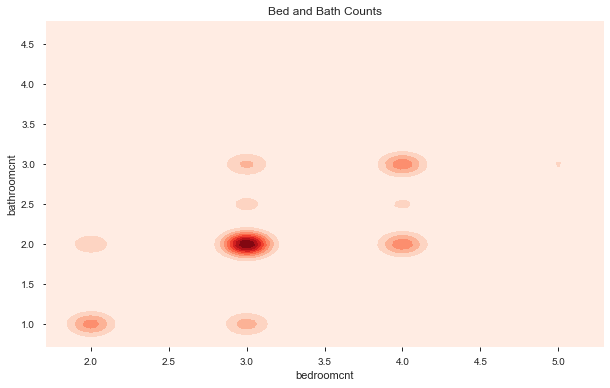

In [64]:
# kernal density estimate (kde) chart to show most common combination of bed and bath count
plt.rcParams["figure.figsize"] = (10,6)
sns.kdeplot(train.bedroomcnt, train.bathroomcnt, shade=True, cmap='Reds')
plt.title("Bed and Bath Counts")

plt.show()

In [65]:
# contingency_table from the df_cat dataframe (w/o categories)
plt.rcParams["figure.figsize"] = (20,10)

contingency_table = pd.crosstab(train.bedroomcnt, train.bathroomcnt).style.background_gradient(cmap='YlOrRd')
contingency_table

bathroomcnt,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5
bedroomcnt,,,,,,,,
2.0,3529,158,1751,146,180,10,8,0
3.0,2514,336,9325,1337,2271,139,254,25
4.0,151,77,3813,1176,3760,343,694,228
5.0,21,1,233,129,1064,122,454,198


In [66]:
contingency_table = pd.crosstab(train.bedroomcnt, train.bathroomcnt)
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [67]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 0.0.


In [68]:
r, p = stats.pearsonr(train.bedroomcnt, train.bathroomcnt)

In [69]:
print(f"r is {r}")

r is 0.5964368911736606


In [70]:
print(f"p is {p}")

p is 0.0


#### Takeaways: Bedroom and Bathroom

- The typical home is a 3 bedroom, 2 bathroom. This is where the most variation will lie making it the most difficult home values to predict.


- Based on the p_value of 0 from the chi2 test above, I reject the Null Hypothesis that bathroomcnt is independent of how many bedrooms a home has.


- Based on rejecting the Null Hypothesis, it might be useful to combine the two features into a single feature that is a ratio of bedrooms to bathrooms. This may be done in this or a future iteration of this project.

---

### Chi2 test: Garage and Pool counts

- $H_0$: garagecarcnt is independent of how many pools a home has.

- $H_a$: garagecarcnt is not independent of how many pools a home has.

In [71]:
train.head()

,tax_rate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,garagecarcnt,latitude,longitude,lotsizesquarefeet,poolcnt,taxvaluedollarcnt,yearbuilt,landtaxvaluedollarcnt,logerror,county_name,price_per_sq_ft,lot_price_per_sq_ft,cluster_fips,cluster_sqft
22620,0.01,2.00,2.00,"1,212.00","6,059.00",2.00,33.85,-118.02,"6,000.00",0.00,"143,427.00","1,955.00","88,553.00",-0.08,Orange,118.34,14.76,0,1
35532,0.02,2.00,3.00,"1,812.00","6,037.00",0.00,34.05,-118.08,"10,906.00",0.00,"87,511.00","1,957.00","16,333.00",-0.04,Los Angeles,48.30,1.50,1,8
17905,0.01,3.00,4.00,"3,149.00","6,059.00",2.00,33.49,-117.64,"9,000.00",1.00,"1,005,040.00","1,998.00","576,786.00",0.03,Orange,319.16,64.09,0,5
49147,0.01,3.00,4.00,"2,859.00","6,037.00",0.00,34.45,-118.57,"6,252.00",0.00,"644,000.00","2,003.00","330,000.00",0.07,Los Angeles,225.25,52.78,1,9
43935,0.01,3.00,4.00,"2,512.00","6,037.00",0.00,34.16,-118.41,"7,042.00",1.00,"806,181.00","1,974.00","437,002.00",0.08,Los Angeles,320.93,62.06,1,5


In [72]:
plt.rcParams["figure.figsize"] = (20,10)

contingency_table = pd.crosstab(train.garagecarcnt, train.poolcnt).style.background_gradient(cmap='YlOrRd')
contingency_table

poolcnt,0.0,1.0
garagecarcnt,,
0.0,18240,4188
1.0,1287,156
2.0,7800,2284
3.0,175,175
4.0,48,65
5.0,6,9
6.0,4,3
7.0,2,0
8.0,0,1


In [73]:
contingency_table = pd.crosstab(train.garagecarcnt, train.poolcnt)

In [74]:
_, p, _, expected = stats.chi2_contingency(contingency_table)

In [75]:
print(f"The p-value of the contingency test is {p}.")

The p-value of the contingency test is 1.2243181006757053e-92.


In [76]:
r, p = stats.pearsonr(train.lotsizesquarefeet, train.taxvaluedollarcnt)

In [77]:
print(f"r is {r}")

r is 0.014576914372332342


In [78]:
print(f"p is {p}")

p is 0.006820026754083448


#### Takeaways: Garage and Pool

- Most homes do not have a pool or a garage.

- Two car garages are the most common and one pool.

- Since each of these variables would add value to the home value but both have so many missing values, there could be an opportunity for feature engineering combining these two variables into a single column called 'extras'.

---

## Drop unwanted features 

In [79]:
train_cluster_sqft = train_cluster_sqft.drop(columns=['cluster_sqft', 'yearbuilt', 'fips', 'county_name', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])
test_cluster_sqft = test_cluster_sqft.drop(columns=['cluster_sqft', 'yearbuilt', 'fips', 'county_name', 'calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt'])

## Split train and test into X_train, X_test, y_train, y_test to prepare for modeling.

In [80]:
X_train = train_cluster_sqft.drop(columns="logerror")

y_train = train_cluster_sqft[["logerror"]]

X_test = test_cluster_sqft.drop(columns="logerror")

y_test = test_cluster_sqft[["logerror"]]

In [81]:
# Drop columns from test and train used in derived columns and kept for exploration

# train = train.drop(columns=['county_name','calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'yearbuilt'])

In [82]:
# test = test.drop(columns=['county_name','calculatedfinishedsquarefeet', 'lotsizesquarefeet', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'yearbuilt'])

In [83]:
# X_train = train.drop(columns="logerror")

# y_train = train[["logerror"]]

# X_test = test.drop(columns="logerror")

# y_test = test[["logerror"]]

---

## Model 

### Linear Regression Model

In [84]:
X_train.dtypes

tax_rate               float64
bathroomcnt            float64
bedroomcnt             float64
garagecarcnt           float64
latitude               float64
longitude              float64
poolcnt                float64
price_per_sq_ft        float64
lot_price_per_sq_ft    float64
cluster_sqft_0         float64
cluster_sqft_1         float64
cluster_sqft_2         float64
cluster_sqft_3         float64
cluster_sqft_4         float64
cluster_sqft_5         float64
cluster_sqft_6         float64
cluster_sqft_7         float64
cluster_sqft_8         float64
cluster_sqft_9         float64
dtype: object

In [85]:
# create the LR object

lm1 = LinearRegression()
print(lm1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)


In [86]:
# fit/train the model

model = lm1.fit(X_train, y_train)

In [87]:
# create yhat variable, numpy array, in-sample prediction values

yhat = model.predict(X_train)
yhat

array([[0.03065187],
       [0.02873786],
       [0.02634659],
       ...,
       [0.01626086],
       [0.02707324],
       [0.03718462]])

#### Evaluate:  LR Model

In [88]:
actual = y_train
actual['yhat'] = yhat
actual["residual"] = actual["yhat"] - actual["logerror"]
actual["residual^2"] = actual["residual"] ** 2

actual.head()

,logerror,yhat,residual,residual^2
22620,-0.08,0.03,0.11,0.01
35532,-0.04,0.03,0.06,0.00
17905,0.03,0.03,-0.00,0.00
49147,0.07,0.02,-0.05,0.00
43935,0.08,0.01,-0.07,0.00


In [89]:
sse = sum(actual["residual^2"])
mse = sse / len(actual)
print(f"mse = {mse}")
rmse = sqrt(mse)
print(f"rmse = {rmse}")

mse = 0.03098721144461913
rmse = 0.1760318478134543


In [90]:
df_eval = pd.DataFrame(np.array(["SSE", "MSE", "RMSE"]), columns=["metric"])
df_eval["model_error"] = np.array([sse, mse, rmse])
df_eval

,metric,model_error
0,SSE,"1,122.91"
1,MSE,0.03
2,RMSE,0.18


In [91]:
mse_lm1 = mean_squared_error(actual.logerror, actual.yhat)
print("linear model\n  mean squared error: {:.3}".format(mse_lm1)) 

r2_lm1 = r2_score(actual.logerror, actual.yhat)
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2_lm1))

linear model
  mean squared error: 0.031
  0.57% of the variance in the logerror can be explained by variables.


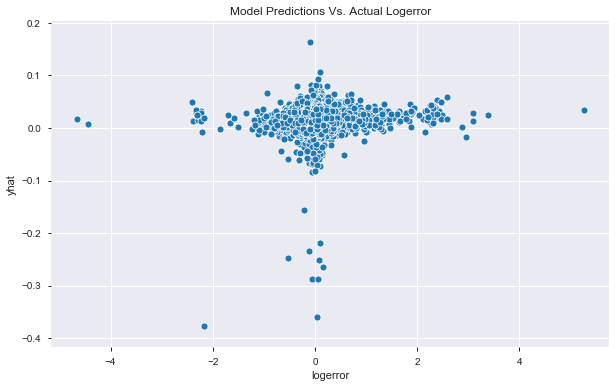

In [92]:
plt.rcParams["figure.figsize"] = (10,6)

sns.scatterplot(actual["logerror"], actual["yhat"])


plt.title('Model Predictions Vs. Actual Logerror')
plt.show()

#### Takeaways:  Linear Regression Model:

- Based on the results above I fail to reject the Null Hypothesis that the numeric values alone can predict the logerror.

- Using a Linear Regression model to predict the logerror may not be the best choice.

- Finding a way to include categorical variables in a model may help predict logerror.

---

### K Neighbors Regressor

In [93]:
# create the object
neigh = KNeighborsRegressor(n_neighbors=2)

In [94]:
# fit/train the model using train 
neigh.fit(X_train, y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                    weights='uniform')

In [95]:
yhat = neigh.predict(X_train)

#### Evaluate:  KNeighbors Regression

In [96]:
actual = y_train
actual['yhat'] = yhat
actual["residual"] = actual["yhat"] - actual["logerror"]
actual["residual^2"] = actual["residual"] ** 2

actual.head()

,logerror,yhat,residual,residual^2
22620,-0.08,-0.01,0.08,0.01
35532,-0.04,-0.02,0.02,0.00
17905,0.03,-0.00,-0.03,0.00
49147,0.07,0.02,-0.04,0.00
43935,0.08,0.05,-0.03,0.00


In [97]:
r2 = neigh.score(X_train, y_train)

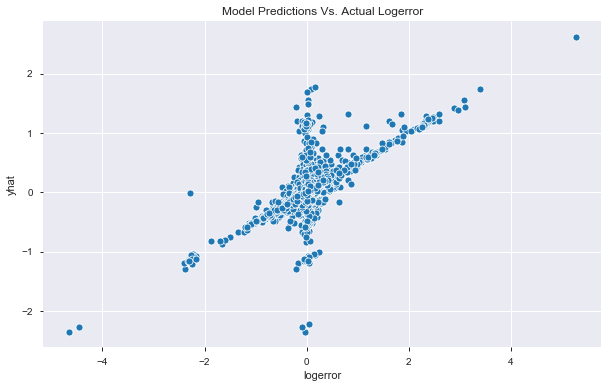

In [98]:
plt.rcParams["figure.figsize"] = (10,6)

sns.scatterplot(actual["logerror"], actual["yhat"])

plt.title('Model Predictions Vs. Actual Logerror')
plt.show()

In [99]:
MSE = mean_squared_error(y_train, yhat)

In [100]:
r2 = neigh.score(X_train, y_train)

In [101]:
print('{:.4} is the mean squared error.'.format(MSE))
print('  {:.2%} of the variance in the logerror can be explained by variables.'.format(r2))

0.01837 is the mean squared error.
  58.25% of the variance in the logerror can be explained by variables.


#### Takeaways:  KNRegressor Model

- This model explained more than 58% more of the variance in logerror than my LR model using exactly the same data.

- This is much better than the LR model, but it leaves much to be desired. 

- We will try another type of model before trying to improve on this one with more feature engineering.

---

### Random Forest Regressor

In [142]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix


import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [143]:
rf = RandomForestRegressor(n_estimators=10)

In [144]:
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

#### Evaluate:  Random Forest Regressor

In [145]:
X_test.head()

,tax_rate,bathroomcnt,bedroomcnt,garagecarcnt,latitude,longitude,poolcnt,price_per_sq_ft,lot_price_per_sq_ft,cluster_sqft_0,cluster_sqft_1,cluster_sqft_2,cluster_sqft_3,cluster_sqft_4,cluster_sqft_5,cluster_sqft_6,cluster_sqft_7,cluster_sqft_8,cluster_sqft_9
10408,0.03,2.00,3.00,0.00,34.58,-118.06,0.00,61.34,3.86,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
38980,0.01,3.00,5.00,0.00,34.17,-118.45,0.00,281.88,62.75,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
34986,0.01,2.50,3.00,2.00,33.62,-117.65,1.00,140.42,21.43,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
28445,0.01,2.50,4.00,2.00,33.53,-117.67,0.00,186.57,61.92,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
48292,0.01,2.00,4.00,1.00,33.81,-117.98,0.00,217.06,28.32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00


In [146]:
from sklearn.metrics import mean_squared_error

y_pred = rf.predict(X_train)
print(f'root mean squared error = {mean_squared_error(y_train, y_pred)**1/2}')

root mean squared error = 0.0020609838082713016


In [147]:
y_pred_test = rf.predict(X_test)

In [148]:
print(f'root mean squared error = {mean_squared_error(y_test, y_pred_test)**1/2}')

ValueError: y_true and y_pred have different number of output (1!=4)

#### Takeaways:  Random Forest Regressor

In [149]:
predictions_vs_actual = pd.DataFrame({'predictions_log_error': y_pred, 'actual_log_error': y_test.logerror})

Exception: Data must be 1-dimensional

In [150]:
sns.scatterplot(data=predictions_vs_actual, x='predictions_log_error', y='actual_log_error', hue="cluster")

NameError: name 'predictions_vs_actual' is not defined

In [151]:
rf.score(X_train, y_train.logerror)

ValueError: y_true and y_pred have different number of output (1!=4)